In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [2]:
def char_tokenize(sequence):
    return list(sequence)

In [3]:
class SimpleGPT(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, hidden_dim, num_layers, num_heads):
        super(SimpleGPT, self).__init__()
        
        self.embedding = nn.Embedding(vocab_dim, embedding_dim)
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim)
            for _ in range(num_layers)
        ])
        self.linear = nn.Linear(embedding_dim, vocab_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.linear(x)
        x = x.permute(0, 2, 1)
        return x

In [4]:
def text2tensor(sequence, token2idx, input_len, vocab):
    new_sequence = [token2idx['<BOS>'], ]
    mask = [1, ]
    seq_len = len(sequence)
    for i in range(input_len - 2):
        is_end = True
        if i < seq_len - 3:
            if sequence[i] in vocab:
                new_sequence.append(token2idx[sequence[i]])
                mask.append(1)
            else:
                new_sequence.append(token2idx['<UNK>'])
                mask.append(0)
        else:
            if is_end:
                mask.append(1)
                is_end = False
            else:
                mask.append(0)

            new_sequence.append(token2idx['<EOS>'])
    
    if seq_len > input_len:
        mask.append(1)
    else:
        mask.append(0)
    new_sequence.append(token2idx['<EOS>'])

    new_sequence = torch.tensor(new_sequence)
    mask = torch.tensor(mask)
    assert len(new_sequence) == input_len, f'{len(new_sequence), input_len, seq_len}'
    return new_sequence, mask

In [5]:
class TextDataset(Dataset):
    def __init__(self, data, tokenizer, token2idx, input_len, vocab):
        self.data = data
        self.tokenizer = tokenizer
        self.token2idx = token2idx
        self.input_len = input_len
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data.iloc[idx, 0]
        sequence = self.tokenizer(sequence)
        sequence, mask = text2tensor(sequence, self.token2idx, self.input_len, self.vocab)
        return sequence[:-1], sequence[1:], mask[1:]


In [6]:
def get_vocabulary(data, ban_words, new_words, vocab_size, tokenizer, threshold):
    vocabulary = {new_word: 1 for new_word in new_words}
    filtered_vocabulary = new_words
    count = len(vocabulary)
    for frame in tqdm(data):
        for i in trange(len(frame)):
            sequence = frame.iloc[i, 0]
            for token in tokenizer(sequence):
                if token not in ban_words and count < vocab_size:
                    if token not in vocabulary:
                        vocabulary[token] = 1
                    else:
                        vocabulary[token] += 1
                    count += 1

    for token, count in vocabulary.items():
        if count > threshold:
           filtered_vocabulary.append(token)

    print(f'Vocabulary len={len(filtered_vocabulary)}')
    return filtered_vocabulary

In [7]:
def choose_device(model, device, parallel_type):
    if device == 'cpu':
        model = model.to(device)
        print(f'device={device}')
    else:
        if parallel_type == 'ddp':
            model = torch.nn.parallel.DistributedDataParallel(model)
            print(f'devices={list(range(torch.cuda.device_count()))}')
        elif parallel_type == 'dp':
            model = torch.nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
            model = model.to(device)
            print(f'devices={list(range(torch.cuda.device_count()))}')
        elif parallel_type is None:
            print(f'devices={[0]}')
            model = model.to(device)

    return model

In [8]:
def save_training(losses, best_epoch):
    print(f'Training is complete, best epoch: {best_epoch}')

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(losses['train'], label='Train Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss value')
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(losses['valid'], label='Valid Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss value')
    axs[1].grid()
    axs[1].legend()

    plt.show()

In [9]:
def train_loop(model, dataloader, loss_func, optimizer, parallel_type, device, early_stopping, scheduler=None, epochs=10):
    losses = {
        'train': [],
        'valid': []
    }
    best_loss = np.inf
    best_epoch = 0
    best_model = None
    
    for epoch in range(epochs):
        for phase in ('train', 'valid'):
            total_loss = 0
            for batch in tqdm(dataloader[phase]):
                inputs, labels, mask = batch
                inputs, labels, mask = inputs.to(device), labels.to(device), mask.to(device)
                
                model.train(phase == 'train')
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    loss = (loss * mask).sum()
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)
                        loss = (loss * mask).sum()

                batch_loss = loss.item() / mask.sum()
                losses[phase].append(batch_loss.detach().cpu().numpy())
                total_loss += batch_loss
            

            epoch_loss = total_loss / len(dataloader)

            if phase =='train' and scheduler is not None:
                scheduler.step()

            if phase == 'valid':
                print('Epoch', epoch+1)
                print('Train Loss:', losses['train'][-1])
                print('Valid Loss:', losses['valid'][-1])
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model = model
                    best_epoch = epoch
                    print('Best score!')
                if epoch - best_epoch == early_stopping:
                    save_training(
                        losses, best_epoch
                    )
                    if parallel_type == None:
                        return best_model
                    else:
                        return best_model.module

                print()

    save_training(
        losses, best_epoch
    )

    if parallel_type == None:
        return best_model
    else:
        return best_model.module


In [10]:
def set_seed(seed):
    np.random.seed(seed)
    np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [11]:
def softmax(x, T=1.0, eps=1e-8):
    if T == 1:
        x_sum = x.sum()
        return x / x_sum
    else:
        x_exp = np.exp(x / T + eps)
        x_sum = x_exp.sum()
        return x_exp / x_sum

In [12]:
def test(best_model, prompt,  tokenizer, token2idx, idx2token, vocabulary, device, generation_len=100, T=1, use_argmax=True):
    best_model.eval()
    with torch.no_grad():
        while True:
            sequence = tokenizer(prompt)
            sequence, mask = text2tensor(prompt, token2idx, len(sequence), vocabulary)
            sequence = sequence[:-1].to(device)
            sequence = sequence.unsqueeze(0)
            pred = best_model(sequence).squeeze(0).cpu().numpy()[:, -1]
            # probs = torch.softmax(last_logits, 0).cpu()
            probs = softmax(pred, T=T)
            if use_argmax:
                next_token = idx2token[probs.argmax(0)]
            else:
                next_token = np.random.choice(vocabulary, p=probs)

            prompt = prompt + next_token

            if next_token == '<EOS>' or len(prompt) > generation_len:
                break

    return prompt        

In [13]:
train_path = r'/root/storage/3030/AkhmetzyanovD/projects/mai/cnn_dailymail/train.csv'
valid_path = r'/root/storage/3030/AkhmetzyanovD/projects/mai/cnn_dailymail/valid.csv'
train_data = pd.read_csv(train_path, usecols=['article'])
valid_data = pd.read_csv(valid_path, usecols=['article'])

In [14]:
train_data = train_data.head(int(len(train_data) / 4))

In [15]:
train_data.head(10)

,article
0,By . Associated Press . PUBLISHED: . 14:11 EST...
1,(CNN) -- Ralph Mata was an internal affairs li...
2,A drunk driver who killed a young woman in a h...
3,(CNN) -- With a breezy sweep of his pen Presid...
4,Fleetwood are the only team still to have a 10...
5,He's been accused of making many a fashion fau...
6,By . Daily Mail Reporter . PUBLISHED: . 01:15 ...
7,By . Daily Mail Reporter . This is the moment ...
8,There are a number of job descriptions waiting...
9,"Canberra, Australia (CNN) -- At first glance, ..."


In [16]:
device = 'cuda:0'
parallel_type = 'dp'

In [17]:
prompt = 'This will create a '

## GPT with char tokenizer

In [18]:
ban_words = ['\t', '\n', '\u2009', '\xa0', '|', '´', '’',  '‘', '–', 'ñ', 'â' , '“', '½', 'Î', 'í', 'ó', 'Â', 'Ã', 'ﬁ', '¿', '•', 'É', 'è', 'š', 'ū', 'ė', 'č', '¢', 'é', 'ô']
new_words = ['<EOS>', '<BOS>', '<UNK>']
vocabulary = ['<EOS>', '<BOS>', '<UNK>', 'B', 'y', ' ', '.', 'A', 's', 'o', 'c', 'i', 'a', 't', 'e', 'd', 'P', 'r', 'U', 'L', 'I', 'S', 'H', 'E', 'D', ':', '1', '4', 'T', ',', '2', '5', 'O', 'b', '0', '3', '6', 'h', 'p', 'f', 'F', 'g', 'C', 'l', 'n', 'N', 'k', 'x', 'u', 'm', 'G', 'J', 'w', 'v', '(', ')', 'z', 'M', "'", '-', 'R', '"', '9', 'K', 'W', 'j', '7', '8', '[', ']', 'Y', 'q', 'V', '$', '%', 'Q', '£', '/', '!', 'Z', '¬', '#', ';', '©', '&', '@', '_', '?', '*', 'X', '—', '+', '…', '»', '”', '€', '<', '{', '}']
vocab_size = 99
# vocabulary =  get_vocabulary([train_data, valid_data], ban_words, new_words, vocab_size, word_tokenize, 0)
vocab_size = len(vocabulary)

In [19]:
token2idx = {token: i for i, token in enumerate(vocabulary)}
idx2token = {i: token for i, token in enumerate(vocabulary)}

In [20]:
train_dataset = TextDataset(train_data, char_tokenize, token2idx, input_len=512, vocab=vocabulary)
valid_dataset = TextDataset(valid_data, char_tokenize, token2idx, input_len=512, vocab=vocabulary)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

In [22]:
model = SimpleGPT(vocab_dim=vocab_size, embedding_dim=300, hidden_dim=128, num_layers=5, num_heads=4)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
scheduler = None

In [23]:
model = choose_device(model, device, parallel_type)

devices=[0, 1]


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Epoch 1
Train Loss: 2.546581
Valid Loss: 2.5757039
Best score!



100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Epoch 2
Train Loss: 2.5409434
Valid Loss: 2.5818312
Best score!



100%|██████████| 27/27 [00:18<00:00,  1.42it/s]


Epoch 3
Train Loss: 2.5360868
Valid Loss: 2.5777106
Best score!

Training is complete, best epoch: 2


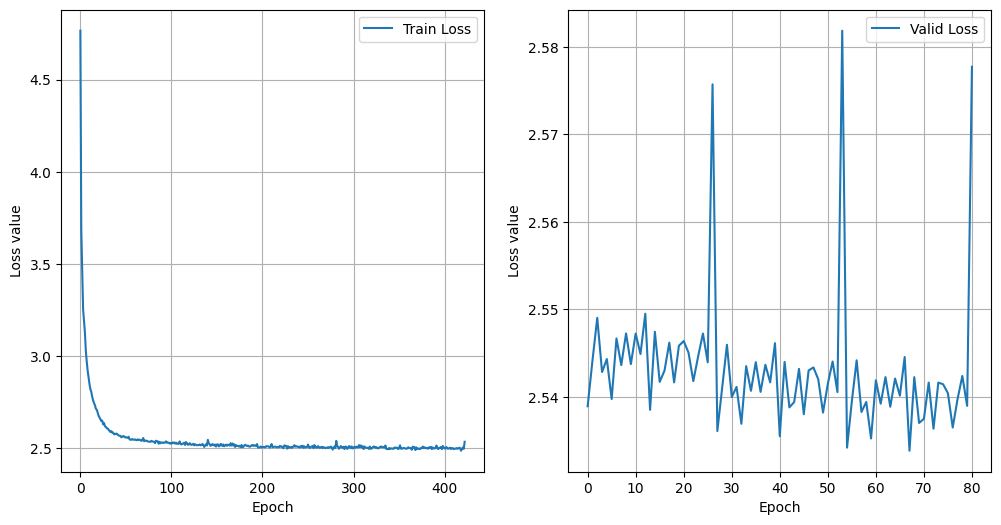

In [24]:
best_model = train_loop(
    model=model, 
    dataloader=dataloaders, 
    loss_func=loss_fn,
    optimizer=optimizer,
    parallel_type=parallel_type, 
    device=device, 
    early_stopping=3,
    scheduler=scheduler, 
    epochs=3
    )

In [25]:
text1 = test(
    best_model, 
    prompt, 
    char_tokenize, 
    token2idx, 
    idx2token, 
    vocabulary, 
    device, 
    generation_len=100, 
    T=0.4, 
    use_argmax=True
)

In [26]:
print('This will create a ')

This will create a <EOS>


: 